<a href="https://colab.research.google.com/github/kd365/faafall22/blob/main/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NTSB Cleaning Notebook

## Steps:
1. Import libraries and raw data
2. Initial column drops
3. Cleaning steps that wil apply to entire dataframe
4. Cleaning each column

**Cleaning Plan:**
Hunter:
- cols 0-22
Kathleen:
- col 23-45
Eric:
- col 46-68
Chi:
- col 69-85


### 1. Import libraries

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving NTSB_for_cleaning.csv to NTSB_for_cleaning.csv


In [ ]:
import re
import numpy as np

In [ ]:
# setting pandas display options
pd.set_option('display.max_rows', 150)

# reading in NTSB csv file
ntsb_raw = pd.read_csv("NTSB_for_cleaning.csv", encoding='latin-1', low_memory=False)
ntsb_raw = ntsb_raw.drop(['engines_ev_id', 'events_ev_id', 'Unnamed: 0'], axis=1)
# view the dataframe info
ntsb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112803 entries, 0 to 112802
Data columns (total 86 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   aircraft_ev_id         112803 non-null  object 
 1   far_part               112080 non-null  object 
 2   flight_plan_activated  48716 non-null   object 
 3   damage                 111402 non-null  object 
 4   acft_make              112785 non-null  object 
 5   acft_model             112767 non-null  object 
 6   cert_max_gr_wt         98437 non-null   float64
 7   num_eng                110047 non-null  float64
 8   type_last_insp         104108 non-null  object 
 9   date_last_insp         87193 non-null   object 
 10  afm_hrs_last_insp      61174 non-null   float64
 11  afm_hrs                88035 non-null   float64
 12  type_fly               108038 non-null  object 
 13  dprt_apt_id            90502 non-null   object 
 14  dprt_city              94336 non-nul

### 2. Initial Drop

In [ ]:
# need to delete duplicate records
ntsb_raw = ntsb_raw.drop_duplicates(subset='aircraft_ev_id', keep='last')
ntsb_raw.shape

(69635, 86)

In [ ]:
# drop all records that do not have at least 50 columns worth of data in them
ntsb_raw = ntsb_raw.dropna(thresh=60)

In [ ]:
# drop any columns that have more than 40% null values
total_rows = ntsb_raw.shape[0]

def drop_cols(df, df_size):
    # create a list of columns to drop
    drop = []
    # iterate over each column
    for x in df.columns:
        #determine if the ratio of nulls is greater than 30%
        ratio = (df[x].isna().sum()) / df_size
        if ratio > 0.5:
            drop.append(x)
    # drop the columns in the drop list
    df.drop(labels=drop, axis=1)
    print('Cols dropped from df:', drop)
    return df

ntsb_dropped_cols = drop_cols(ntsb_raw, total_rows)      


Cols dropped from df: ['flight_plan_activated', 'afm_hrs_since', 'eng_time_total', 'eng_time_last_insp', 'latitude', 'longitude', 'wx_dens_alt', 'Cause_Factor', 'crew_no', 'crew_category', 'crew_age', 'crew_sex', 'med_certf', 'crew_inj_level']


In [ ]:
print(ntsb_dropped_cols.shape)

(57686, 86)


## 3. Cleaning that applies to entire data set

In [ ]:
# function to initially clean up all strings in df
def df_string_transform(df):
    ''' 
    force all text data to lowercase and strip left and right side of strings
    in all string columns

    args: dataframe

    returns: dataframe
    '''
    df1 = df.applymap(lambda x: x.lower() if type(x) == str else x)
    df1 = df1.applymap(lambda x: x.strip() if type(x) == str else x)
    return df1

In [ ]:
# applying the funcrition from above
ntsb_1 = df_string_transform(ntsb_dropped_cols)

In [ ]:
print(ntsb_1.shape)

(57686, 86)


**NOTE**: for section 3 use the dataframe `ntsb_1` for cleaning

### 3. Cleaning Each Column

In [ ]:
# function to show all the metrics you will want to see for each column
def col_metrics(df, col='none'):
  print('current df shape:', df.shape)
  print('Unique data: ', df[col].unique())
  print('Value counts: ', df[col].value_counts())
  print('Total nulls: ', df[col].isna().sum())
  print('Data type: ', df[col].dtypes)

### HUNTER'S SECTION

In [ ]:
# column 1: far part
col_metrics(ntsb_1, col='far_part')      

# making a copy of the data set as ntsb_1
ntsb_1 = pd.DataFrame.copy(ntsb_1)

# remove the K and F from part 091
ntsb_1['far_part'] = ntsb_1['far_part'].str.replace('k', '').str.replace('f', '').str.replace('arm', '091')
print(ntsb_1['far_part'].unique())

current df shape: (57686, 86)
Unique data:  ['135' '091' '137' '103' 'armf' '091f' '091k' '437']
Value counts:  091     51939
135      2816
137      2790
103        90
091f       30
091k       11
armf        9
437         1
Name: far_part, dtype: int64
Total nulls:  0
Data type:  object
['135' '091' '137' '103' '437']


In [ ]:
# column 2: 'flight_plan_activated'
col_metrics(ntsb_1, 'flight_plan_activated')

# dropping this column, too many nulls, and filing a flight plan is superfluous 
#because you can file in flight or you can use flight following
ntsb_1 = ntsb_1.drop(['flight_plan_activated'], axis=1)

current df shape: (57686, 86)
Unique data:  [nan 'y' 'n' 'u']
Value counts:  n    11604
y     3022
u      344
Name: flight_plan_activated, dtype: int64
Total nulls:  42716
Data type:  object


In [ ]:
# column 3: 'damage'
col_metrics(ntsb_1, 'damage')

# change the unk to none
ntsb_1['damage'] = ntsb_1['damage'].str.replace('unk', 'none')
# drop the 491 rows that do not have a damage listing
ntsb_1 = ntsb_1.dropna(subset='damage')
print('final null count:', ntsb_1['damage'].isna().sum())

current df shape: (57686, 85)
Unique data:  ['subs' 'dest' 'none' 'minr' 'unk' nan]
Value counts:  subs    43662
dest    12728
minr      913
none      277
unk         9
Name: damage, dtype: int64
Total nulls:  97
Data type:  object
final null count: 0


In [ ]:
# column 4: 'acft_make'
col_metrics(ntsb_1, 'acft_make')

# there are 6 rosw with nulls, will drop those
ntsb_1 = ntsb_1.dropna(subset=['acft_make'])
print(ntsb_1['acft_make'].isna().sum())

current df shape: (57589, 85)
Unique data:  ['cessna' 'piper' 'beech' ... 'gerald nelson' 'gonzalez manuel a'
 'harris-runyan']
Value counts:  cessna                      20123
piper                       10858
beech                        4099
bell                         1272
mooney                       1046
                            ...  
gary e. wilson                  1
lonnie w. ratliff               1
silvaggio                       1
s. piccolotto/dave morss        1
harris-runyan                   1
Name: acft_make, Length: 5333, dtype: int64
Total nulls:  8
Data type:  object
0


In [ ]:
# column 5: 'acft_model'
col_metrics(ntsb_1, 'acft_model')

# drop the 5 rows that have nulls
ntsb_1 = ntsb_1.dropna(subset=['acft_model'])

current df shape: (57581, 85)
Unique data:  ['207' 'pa-22-160' '300' ... 'rv 7' 'f4u 5' 'skybolt 300']
Value counts:  152                  1940
172                  1045
172n                  927
pa-28-140             779
172m                  646
                     ... 
tu-10                   1
as 355 f ecureuil       1
be35g                   1
twinstar ta-2           1
skybolt 300             1
Name: acft_model, Length: 7832, dtype: int64
Total nulls:  19
Data type:  object


In [ ]:
# column 5

# remove the letters off the cessna model
pattern = r'\d\d\d\w'
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: re.sub(pattern, lambda match: match.group()[:-1], x))
print(ntsb_1['acft_model'].value_counts())

#if an aircraft make is not in the top 30, it will be categorized as other. 
model_top_30 = ntsb_1['acft_model'].value_counts()[0:30].index.tolist()

# change the model names to 'other_model' if not in the top 30
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: 'other_model' if x not in model_top_30 else x)

172                4555
150                2509
152                1956
182                1910
pa-28-140           796
                   ... 
b-100                 1
panther ii plus       1
musting ii            1
g-102 astir cs        1
skybolt 300           1
Name: acft_model, Length: 7235, dtype: int64


In [ ]:
# column 6: 'cert_max_gr_wt'
col_metrics(ntsb_1, 'cert_max_gr_wt')
print(ntsb_1['cert_max_gr_wt'].max(), ntsb_1['cert_max_gr_wt'].min())

def weight_bins(df, col):
    avg_wt = df[col].mean()    
    wt_cat = []
    for x in list(df[col]):
        if x <= 12500:
            x = 'small'
            wt_cat.append(x)
        elif x > 12500 and x < 41000:
            x = 'medium'
            wt_cat.append(x)
        elif x == 'nan':
            if avg_wt <=12500:
                x = 'small'
                wt_cat.append(x)
            elif avg_wt > 12500 and x < 41000:
                x = 'medium'
                wt_cat.append(x)
            else:
                x = 'large commuter'
                wt_cat.append(x)
        else:
            x = 'large commuter'
            wt_cat.append(x)
    df[col] = wt_cat
    return df[col]

current df shape: (57562, 85)
Unique data:  [ 3800.  1840. 14100. ...  5333.  2497.  2251.]
Value counts:  1600.0      2600
2300.0      2597
1670.0      2224
3600.0      1533
2150.0      1530
            ... 
1297.0         1
22450.0        1
3609.0         1
358000.0       1
2251.0         1
Name: cert_max_gr_wt, Length: 2168, dtype: int64
Total nulls:  3060
Data type:  float64
870000.0 -3100.0


In [ ]:
# use the bin function to assign categories to weight classes
ntsb_1['cert_max_gr_wt'] = weight_bins(ntsb_1, 'cert_max_gr_wt')

In [ ]:
# column 7: 'num_eng'
col_metrics(ntsb_1, 'num_eng')

# convert the float to int and then impute the nulls with the median
ntsb_1['num_eng'] = ntsb_1['num_eng']

current df shape: (57562, 85)
Unique data:  [ 1.  2. nan  3.  4.  0.]
Value counts:  1.0    49699
2.0     6830
0.0      505
4.0       47
3.0       31
Name: num_eng, dtype: int64
Total nulls:  450
Data type:  float64


In [ ]:
# change from float to int8
# fill na with 1
ntsb_1['num_eng'] = ntsb_1['num_eng'].fillna(1.0).astype('int8')


In [ ]:
# column 8: 'type_last_insp'
col_metrics(ntsb_1, 'type_last_insp')
ntsb_1['type_last_insp'] = ntsb_1['type_last_insp'].fillna('unk')

current df shape: (57562, 85)
Unique data:  ['100h' 'aaip' 'annl' 'unk' 'coaw' 'cond' nan]
Value counts:  annl    33108
unk      9332
100h     9106
cond     1716
aaip     1614
coaw     1478
Name: type_last_insp, dtype: int64
Total nulls:  1208
Data type:  object


In [ ]:
# column 9: 'afm_hrs'
col_metrics(ntsb_1, 'afm_hrs')

current df shape: (57562, 85)
Unique data:  [10286.  14424.      nan ...  2341.8    53.2   967.5]
Value counts:  1.0        129
3000.0     105
2500.0      94
2000.0      90
4000.0      84
          ... 
8725.0       1
12005.0      1
6072.0       1
4976.0       1
967.5        1
Name: afm_hrs, Length: 13131, dtype: int64
Total nulls:  10560
Data type:  float64


In [ ]:
ntsb_1['afm_hrs'].describe()

count     47002.000000
mean       3639.729272
std        4530.201239
min           0.000000
25%        1284.250000
50%        2711.900000
75%        4547.000000
max      233109.000000
Name: afm_hrs, dtype: float64

In [ ]:
# count how many values are outliers
outlier = (1.5*(4752 - 1229)) + 4752
outliers = [x for x in ntsb_1['afm_hrs'] if x > outlier]
print(len(outliers))

2322


In [ ]:
# fill na with median
#median = ntsb_1['afm_hrs'].median()
#ntsb_1['afm_hrs'] = ntsb_1['afm_hrs'].fillna(median)
# drop the outliers
ntsb_1 = ntsb_1[ntsb_1['afm_hrs'] < outlier]


<Axes: ylabel='Frequency'>

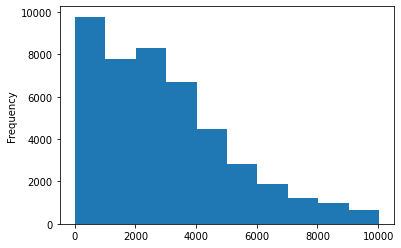

In [ ]:
ntsb_1['afm_hrs'].plot.hist(bins=10)

In [ ]:
ntsb_1.shape

(44680, 85)

In [ ]:
# round and change to int32
ntsb_1['afm_hrs'] = ntsb_1['afm_hrs'].round().astype('int16')

In [ ]:
# column 10: 'type_fly'
col_metrics(ntsb_1, 'type_fly')

current df shape: (44680, 85)
Unique data:  ['exec' 'pers' 'bus' 'inst' 'unk' 'pubu' 'posi' 'fery' 'owrk' 'aapl'
 'aobv' 'skyd' nan 'flts' 'asho' 'adrp' 'gldt' 'bant' 'publ' 'pubs' 'exld'
 'pubf' 'firf']
Value counts:  pers    28193
inst     6086
unk      2551
bus      2430
aapl     2066
posi      788
fery      449
owrk      434
exec      375
aobv      308
pubu      203
flts      201
skyd       71
asho       69
bant       46
gldt       19
pubs       12
publ        7
adrp        5
exld        5
pubf        5
firf        1
Name: type_fly, dtype: int64
Total nulls:  356
Data type:  object


In [ ]:
# change the null to unknown
ntsb_1['type_fly'] = ntsb_1['type_fly'].fillna('unk')

In [ ]:
# column 11: 'dprt_apt_id'
col_metrics(ntsb_1, 'dprt_apt_id')

# need to drop the 'k' from all 4 letter icao's
ntsb_1['dprt_apt_id'] = ntsb_1['dprt_apt_id'].astype('str').apply(lambda x: x[1:] if len(x) == 4 and x[0] == 'k' else x)

current df shape: (44680, 85)
Unique data:  ['gmu' 'ox8' nan ... '37f' '62k' '38cl']
Value counts:  none    825
pvt     253
c       168
mri     164
apa     134
       ... 
ape       1
mkcr      1
neo8      1
0k9       1
38cl      1
Name: dprt_apt_id, Length: 7702, dtype: int64
Total nulls:  9657
Data type:  object


In [ ]:
# column 12: 'dprt_city'
col_metrics(ntsb_1, 'dprt_city')

current df shape: (44680, 85)
Unique data:  ['greeneville' nan 'detroit city' ... 'kalaeloa' 'ishpeming' 'munday']
Value counts:  anchorage          330
las vegas          148
houston            145
columbus           138
fairbanks          129
                  ... 
kroto slough         1
big lake,ak          1
nunavarchak bch      1
denali airstrip      1
munday               1
Name: dprt_city, Length: 6753, dtype: int64
Total nulls:  9638
Data type:  object


In [ ]:
# there are some city names that have commas and states after. remove those with commas
ntsb_1['dprt_city'] = ntsb_1['dprt_city'].str.split(',').str[0]


In [ ]:
# column 13: 'dprt_state'
col_metrics(ntsb_1, 'dprt_state')

current df shape: (44680, 85)
Unique data:  ['sc' nan 'mi' 'mn' 'il' 'ks' 'mo' 'oh' 'ne' 'az' 'nm' 'tx' 'la' 'ok' 'in'
 'ca' 'me' 'or' 'ak' 'ga' 'co' 'nh' 'nv' 'fl' 'ma' 'de' 'pa' 'ct' 'ms'
 'al' 'nc' 'wy' 'tn' 'nj' 'hi' 'ky' 'vi' 'id' 'wa' 'ut' 'ar' 'va' 'pr'
 'ny' 'wv' 'mt' 'nd' 'vt' 'dc' 'ri' 'sd' 'ia' 'cd' 'md' 'wi' 'of' 'ah'
 'cn' 'bc' 'gm' 'mp' 'po' 'yt' 'mx' 'un' 'bh' 'ad' 'nb' 'pq' 'cb' 'gu'
 'ha' 'io' 'kn' 'ja' 'bi' 'ao' 'dr']
Value counts:  ca    3864
fl    2569
tx    2354
ak    1913
az    1247
co    1141
wa    1085
ga     974
mi     881
oh     873
ny     871
il     870
pa     851
nc     773
mo     708
wi     676
or     668
mn     637
va     612
in     577
id     576
nv     562
tn     559
nj     559
ut     557
nm     551
ar     545
al     529
ks     517
ok     513
sc     476
la     440
mt     408
ma     404
md     390
ia     366
ms     349
ne     326
ky     304
wy     299
me     258
ct     237
nd     235
sd     220
wv     187
nh     186
hi     174
vt     110
pr      89
ri    

In [ ]:
# print out all the states that are incorrect
state_abbr = [
    "AL",  # Alabama
    "AK",  # Alaska
    "AZ",  # Arizona
    "AR",  # Arkansas
    "CA",  # California
    "CO",  # Colorado
    "CT",  # Connecticut
    "DE",  # Delaware
    "FL",  # Florida
    "GA",  # Georgia
    "HI",  # Hawaii
    "ID",  # Idaho
    "IL",  # Illinois
    "IN",  # Indiana
    "IA",  # Iowa
    "KS",  # Kansas
    "KY",  # Kentucky
    "LA",  # Louisiana
    "ME",  # Maine
    "MD",  # Maryland
    "MA",  # Massachusetts
    "MI",  # Michigan
    "MN",  # Minnesota
    "MS",  # Mississippi
    "MO",  # Missouri
    "MT",  # Montana
    "NE",  # Nebraska
    "NV",  # Nevada
    "NH",  # New Hampshire
    "NJ",  # New Jersey
    "NM",  # New Mexico
    "NY",  # New York
    "NC",  # North Carolina
    "ND",  # North Dakota
    "OH",  # Ohio
    "OK",  # Oklahoma
    "OR",  # Oregon
    "PA",  # Pennsylvania
    "RI",  # Rhode Island
    "SC",  # South Carolina
    "SD",  # South Dakota
    "TN",  # Tennessee
    "TX",  # Texas
    "UT",  # Utah
    "VT",  # Vermont
    "VA",  # Virginia
    "WA",  # Washington
    "WV",  # West Virginia
    "WI",  # Wisconsin
    "WY",  # Wyoming
    'gu', 
    'mp', 
    'pr',
    'tt',
    'vi'
]
print(len(state_abbr))
state_abbr = list(map(str.lower, state_abbr))

55


In [ ]:
# incorrect states
wrong_states = set()
state_sum = []
for x in ntsb_1['dprt_state']:
  if (x not in state_abbr) and (x is not np.nan):
      wrong_states.add(x)
      state_sum.append(x)
print(len(state_sum))
print(wrong_states)

# drop the rows with incorrect state values
ntsb_1 = ntsb_1[~ntsb_1['dprt_state'].isin(wrong_states)]

210
{'dr', 'ja', 'of', 'dc', 'pq', 'nb', 'cd', 'yt', 'bc', 'bi', 'ad', 'gm', 'cn', 'un', 'bh', 'ah', 'cb', 'ha', 'mx', 'kn', 'ao', 'io', 'po'}


In [ ]:
ntsb_1.shape

(44470, 85)

In [ ]:
# column 14: 'dprt_time'
col_metrics(ntsb_1, 'dprt_time')

current df shape: (44470, 85)
Unique data:  [ 908. 1710. 1200. ...  156.   29.  322.]
Value counts:  0.0       3620
1400.0     856
1500.0     814
1600.0     737
1700.0     693
          ... 
626.0        1
103.0        1
195.0        1
193.0        1
322.0        1
Name: dprt_time, Length: 1354, dtype: int64
Total nulls:  1514
Data type:  float64


In [ ]:
# change to string
ntsb_1['dprt_time'] = ntsb_1['dprt_time'].astype('str')

# remove all .o
ntsb_1['dprt_time'] = ntsb_1['dprt_time'].str.rstrip('.0')
times = []
for x in list(ntsb_1['dprt_time']):
    if len(x) == 1:
        x = '000' + x
        times.append(x)
    elif len(x) == 2:
        x = '00' + x
        times.append(x)
    elif len(x) == 3:
        x = '0' + x
        times.append(x)
    else:
        times.append(x)
ntsb_1['dprt_time'] = times
ntsb_1['dprt_time'].unique()


array(['0908', '0171', '0012', ..., '0156', '0029', '0322'], dtype=object)

In [ ]:
import numpy as np
# column 15: 'dest_same_local'
col_metrics(ntsb_1, 'dest_same_local')

# three different versions of yes so standatdizing it
ntsb_1['dest_same_local'] = ntsb_1['dest_same_local'].str.replace('same', 'y').str.replace('locl', 'y').str.replace('spec', 'y')

ntsb_1.loc[ntsb_1['dest_same_local'] == 'y', 'dest_apt_id'] = ntsb_1['dest_apt_id'].fillna(ntsb_1['dprt_apt_id'])  
 

current df shape: (44470, 85)
Unique data:  ['y' nan]
Value counts:  y    23102
Name: dest_same_local, dtype: int64
Total nulls:  21368
Data type:  object


In [ ]:
# column 16: 'dest_apt_id'
col_metrics(ntsb_1, 'dest_apt_id')

# need to drop the 'k' from all 4 letter icao's
ntsb_1['dest_apt_id'] = ntsb_1['dest_apt_id'].astype('str').apply(lambda x: x[1:] if len(x) == 4 and x[0] == 'k' else x)
ntsb_1.loc[ntsb_1['dest_apt_id'] == 'c', 'dest_apt_id'] = ntsb_1['dest_apt_id'].str.replace('c', 'pvt')

current df shape: (44470, 85)
Unique data:  ['3a1' 'ox8' 'nan' ... 'vvs' '62k' '38cl']
Value counts:  nan     8644
none     860
pvt      271
c        206
mri      165
        ... 
ny43       1
hlo        1
uo1        1
u98        1
38cl       1
Name: dest_apt_id, Length: 7049, dtype: int64
Total nulls:  0
Data type:  object


In [ ]:
# col 17: 'dest_city'
col_metrics(ntsb_1, 'dest_city')

# there are some city names that have commas and states after. remove those with commas
ntsb_1['dest_city'] = ntsb_1['dest_city'].str.split(',').str[0]

current df shape: (44470, 85)
Unique data:  [nan 'oklahoma city' 'mt. vernon' ... 'langley' 'hicks/fort wort'
 'detroit/grosse ile']
Value counts:  anchorage             187
las vegas             119
houston               107
atlanta                98
phoenix                97
                     ... 
elizabeth               1
oxbow                   1
south charlesto         1
corolla                 1
detroit/grosse ile      1
Name: dest_city, Length: 5772, dtype: int64
Total nulls:  18371
Data type:  object


In [ ]:
# column 18: 'dest_state'
col_metrics(ntsb_1, 'dest_state')

# incorrect states
wrong_states = set()
state_sum = []
for x in ntsb_1['dest_state']:
  if (x not in state_abbr) and (x is not np.nan):
      wrong_states.add(x)
      state_sum.append(x)
print(len(state_sum))
print(wrong_states)

# drop the rows with incorrect state values
ntsb_1 = ntsb_1[~ntsb_1['dest_state'].isin(wrong_states)]

current df shape: (44351, 85)
Unique data:  ['al' nan 'ok' 'il' 'ks' 'co' 'ar' 'ne' 'tx' 'ca' 'fl' 'pa' 'mi' 'az' 'nv'
 'sc' 'ms' 'ct' 'ak' 'ia' 'ut' 'oh' 'tn' 'nc' 'mn' 'mo' 'nm' 'ga' 'or'
 'la' 'nj' 'ky' 'pr' 'wa' 'nh' 'va' 'me' 'ma' 'cg' 'p1' 'id' 'mt' 'in'
 'wi' 'md' 'ny' 'wv' 'ck' 'hi' 'wy' '42' 'de' 'nd' 'no' 'ap' 'vt' 'ri'
 'bm' 'fm' 'fi' 'bu' 'go' 'vn' 'fd' 'ws' 'sd' 'vi' 'dl' 'gc' '0' 'on' 'a'
 '2' 'gu' 'it' 'd' '\x11']
Value counts:  ca    2866
fl    1918
tx    1805
ak    1439
az     938
co     866
wa     832
ga     727
ny     655
oh     623
nc     620
pa     608
mi     606
il     602
or     538
mo     522
wi     495
id     490
mn     478
tn     457
va     450
ut     438
nv     434
in     433
nm     420
al     413
nj     398
ok     397
ks     377
ar     373
sc     371
mt     334
ma     325
la     322
ia     293
md     268
ky     239
ne     236
ms     233
wy     228
me     201
ct     184
nd     157
sd     155
wv     151
hi     128
nh     125
vt      72
pr      60
ri      58
de

In [ ]:
# col 19: phase_flt_spec
col_metrics(ntsb_1, 'phase_flt_spec')

current df shape: (44324, 85)
Unique data:  [560. 520. 540. 570. 580. 530. 550. 510. 590. 553. 574. 569. 565. 522.
 541. 551. 572. 564. 400. 568. 571.  nan 573. 531. 561. 581. 563. 582.
 552. 512. 513. 583. 521. 567. 566. 523. 562. 575. 576. 591. 511. 592.
 542. 514.]
Value counts:  570.0    13742
520.0     4568
550.0     3189
580.0     2901
560.0     2675
540.0     2428
510.0      854
572.0      749
574.0      663
522.0      617
530.0      557
571.0      508
564.0      212
590.0      182
565.0      168
521.0      160
576.0      158
553.0      140
541.0      120
573.0       86
523.0       76
581.0       65
531.0       61
513.0       54
575.0       49
567.0       45
561.0       44
552.0       42
512.0       35
563.0       35
551.0       33
569.0       32
583.0       21
582.0       20
562.0       19
591.0       16
566.0       14
568.0       12
592.0       10
514.0        4
400.0        1
511.0        1
542.0        1
Name: phase_flt_spec, dtype: int64
Total nulls:  8957
Data type:  float

In [ ]:
# col 20: afm_hrs_since
col_metrics(ntsb_1, 'afm_hrs_since')

current df shape: (44324, 85)
Unique data:  [nan 'insp' 'acci' 'n' 'y']
Value counts:  n       4538
y       4348
acci    3934
insp    1858
Name: afm_hrs_since, dtype: int64
Total nulls:  29646
Data type:  object


In [ ]:
ntsb_1.columns

Index(['aircraft_ev_id', 'far_part', 'damage', 'acft_make', 'acft_model',
       'cert_max_gr_wt', 'num_eng', 'type_last_insp', 'date_last_insp',
       'afm_hrs_last_insp', 'afm_hrs', 'type_fly', 'dprt_apt_id', 'dprt_city',
       'dprt_state', 'dprt_time', 'dest_same_local', 'dest_apt_id',
       'dest_city', 'dest_state', 'phase_flt_spec', 'afm_hrs_since', 'rwy_num',
       'rwy_len', 'rwy_width', 'ifr_equipped_cert', 'eng_no', 'eng_type',
       'eng_mfgr', 'hp_or_lbs', 'carb_fuel_injection', 'eng_time_total',
       'eng_time_last_insp', 'ntsb_no', 'ev_type', 'ev_date', 'ev_dow',
       'ev_time', 'ev_city', 'ev_state', 'ev_year', 'ev_month', 'latitude',
       'longitude', 'apt_name', 'ev_nr_apt_id', 'ev_nr_apt_loc', 'apt_dist',
       'apt_dir', 'apt_elev', 'wx_src_iic', 'wx_obs_time', 'wx_obs_dir',
       'wx_obs_fac_id', 'wx_obs_elev', 'wx_obs_dist', 'light_cond',
       'sky_cond_nonceil', 'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil',
       'vis_rvr', 'vis_sm', 'wx_temp'

## Kathleen Section

In [ ]:
ntsb_2 = weight_bins(ntsb_1, 'cert_max_gr_wt')

NameError: ignored

In [ ]:
ntsb_2['cert_max_gr_wt']

NameError: ignored

In [ ]:
ntsb_1.columns

In [ ]:
#Walkthrough at https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html
#preprocessing different for categorical vs numerical columns

from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(ntsb_raw)
categorical_columns = categorical_columns_selector(ntsb_raw)

In [ ]:
#print(df.columns[2])
col_list = ntsb_1.columns[23:46]
print(col_list)

In [ ]:
# Listing metrics for all assigned columns 

for col in col_list:
  print(ntsb_1[col].name)
  col_metrics(ntsb_1, col) 

In [ ]:
# Removing spaces in runway number column. Not sure what else to do with this column, some runways might be more risky for particular airports, so I think this is valuable to keep.
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '0', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '3 r', '3r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '10r/', '10r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '18r/', '18r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '18 /', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '09c', '9c', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02c', '2c', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07s', '7s', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '01l' , '11', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '050', '50', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'unk', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'none', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '03', '3', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07', '7', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07l', '71', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '055', '55', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07l', '71', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '00', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '000', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '08l', '81', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '060' , '60', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '035', '35', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '06r', '6r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07/2', '7', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '03/2', '3', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '08/2', '8', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '03l', '31', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02l', '21', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '05r', '5r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '022', '22', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07r', '7r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '9 r', '9r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '05l', '51', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02r', '2r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07s', '7s', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '2/8', '2', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '09/2', '9', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '04/2', '4', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '05/2', '5', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '12/3', '12', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '14/3', '14', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '15/3', '15', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '10/2', '10', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '11/2', '11', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '16/3', '16', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '18/3', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '17/3', '17', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02/2', '2', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '5/23', '5', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '9/27', '9', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '7/25', '7', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '1/19', '1', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'n', '36', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 's', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'w', '27', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'e', '9', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'e/w', '27', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'n/s', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'nw', '315', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'emm', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'afo', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'gif', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'pvt', 'private', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'se', '135', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'vgt', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'west', '27', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'ne', '4.5', inplace=True) #is this right?
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'vgt', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'sw', '225', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'h2', np.nan, inplace=True)

In [ ]:
## update runway numbers
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '', np.nan, inplace=True)
ntsb_1['rwy_num'].unique()

In [ ]:
col_metrics(ntsb_1, col='rwy_len')

In [ ]:
ntsb_1['rwy_len'].plot(kind='kde')

In [ ]:
# binning values in 'rwy_len' column, wondering the best way to bin since we have values from 0- 69000, but most are between 0-20000

bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 100000]
labels =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
ntsb_1['rwy_len'] = pd.cut(ntsb_1['rwy_len'], bins,labels=labels)
col_metrics(ntsb_1, col='rwy_len')

In [ ]:
col_metrics(ntsb_1, col='rwy_width')

In [ ]:
ntsb_1['rwy_width'].round(0)

In [ ]:
ntsb_1['rwy_width'].max()

In [ ]:
ntsb_1['rwy_width'].plot(kind='kde')

In [ ]:
# binning values in 'rwy_width' column... same question as above

bins2 = [0,10,20,30,40,50,60,70,80,90,100,200,300,400,500,1000,8000]
labels2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

#bins2 = [0, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
#labels2 =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ntsb_1['rwy_width'] = pd.cut(ntsb_1['rwy_width'], bins2, labels=labels2)
col_metrics(ntsb_1, col='rwy_width')

In [ ]:
col_metrics(ntsb_1, col='eng_type')

In [ ]:
# Changing datatype for eng_type column to category
ntsb_1['eng_type'].astype('category')

In [ ]:
#replacing none and unk values from eng_type with nan
ntsb_1['eng_type'].mask(ntsb_1['eng_type'] == 'none', np.nan, inplace=True)
ntsb_1['eng_type'].mask(ntsb_1['eng_type'] == 'unk', np.nan, inplace=True)

In [ ]:
ntsb_1['eng_mfgr'].unique()

In [ ]:
ntsb_1.drop(columns=['hp_or_lbs', 'ntsb_no'])

In [ ]:
#Cleaning names of engine manufacturers.

ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == '1/2 volkswagen', 'volkswagen', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aero engines (vw)', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == '4 burner type engines', '', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ã\x80/o', '', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'â\x82¬', '', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero engines (vw)', 'aero engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport', 'aero sport power', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aero sport power (lycoming)', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport power (lycoming)', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport power ltd', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport power ltd.', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero-vee', 'aero vee', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aeromotors s.a.', 'aero motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerosport', 'aero sport power', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aerosport / lycoming', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerosport / lycoming', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerosport power', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerovee', 'aero vee', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ai', 'airesearch', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aireasearch', 'airesearch', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aireaserch/garrett', 'garrett', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aireaserch/garrett', 'airesearch', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'airresearch', 'airesearch', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'airresearch/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'airresearch/honeywell', 'airesearch', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allied', 'allied signal', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allied/honeyw', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allied/honeyw', 'allied signal', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'alliedsignal', 'allied signal', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison (r/r)', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison (r/r)', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison / rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison / rolls royce', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison 250-c20b', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison c', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison engine', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison rolls royce', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison/rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison/rolls royce', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison/rolls-royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison/rolls-royce', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison/rr', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison/rr', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'alllison', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'ama (vw)', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ama/expr', 'ama', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'ama/expr lycoming)', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ama/expr lycoming', 'ama', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'arriel', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ariel', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'avco', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'avco lycoming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'barrett precision engines', 'barret precision engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'barrett performance engine', 'barret precision engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'bmw r-r', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bmw r-r', 'bmw', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'bmw rolls-royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bmw rolls-royce', 'bmw', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier rotex', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier-rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier/rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bristsidviper', 'Armstrong Siddeley', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'brp rotax gmbh7 co. kg', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cfm', 'cfm international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cfm intl', 'cfm international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cfm intl.', 'cfm international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chapallal', 'elroy air chaparral', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevrolet corvair', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevrolot', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevy', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevy geo metro', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'club crafters inc.', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'compact ra', 'compact radial engines, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'compact radial engines', 'compact radial engines, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'compact radial engines inc.', 'compact radial engines, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continental motor\'s inc', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'conintental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'conitnental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont motor', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'cont motor p. ponk', 'p.ponk', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont motor p. ponk', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont motor/perf eng', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont-motor', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont. motor', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'contenental teledyne', 'teledyne turbine engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental teledyne', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenintal', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'continental teledyne motors', 'teledyne turbine engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continental teledyne motors', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'continental/p. ponk', 'p.ponk', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continental/p. ponk', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continential', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continential motors', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continetal motors', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continetnal', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contintental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contl', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contnental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'corvair', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'covington', 'covington aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cub crafter', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cub crafters', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cubcrafters', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtis - wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtis wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtis-wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtiss', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtiss wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtiswright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'custom', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cuyana', 'cuyuna', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'dehav eng', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'dehavilland', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'detr. diesel', 'detroit diesel', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diamond', 'diamond aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech', 'diemech turbines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'diemech (walter)', 'walter aircraft engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech (walter)', 'diemech turbines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech turbine', 'diemech turbines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech turbines inc', 'diemech turbines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eci', 'engine components, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eci titan', 'engine components, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eci/titan', 'engine components, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eggenfellner', 'eggenfellner aircraft, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'eggenfellner subaru', 'subaru', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eggenfellner subaru', 'eggenfellner aircraft, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'elizalde, s.a.', 'elizalde', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'engine components internationa', 'engine components international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'engineair', 'engineair power systems', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'exp', 'experimental', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'experimental tcm', 'experimental', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'falconer', 'ryan falconer racing engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'falconer eng.', 'ryan falconer racing engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'frankin', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'franklin', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'franklyn', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'frnklin', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'g e', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garett', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garret airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garret airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garret/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garret/honeywell', 'garret', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett research', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett research', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett-airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett-airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett/airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett/airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett/honeywell', 'garret', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ge', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ge aviation czech', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gen.electric', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'general elect', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'general electrics', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'geo/metro', 'geo metro', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gipsy major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gm', 'general motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gm corvair', 'general motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'great plains', 'great plains aircraft supply company', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'great plains/volkswagen', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'great plains/volkswagen', 'great plains aircraft supply company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'great plans aircraft', 'great plains aircraft supply company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'greatplains', 'great plains aircraft supply company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'grob', 'grob aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsey major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsy major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gipsy major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsy minor', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsy moth', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hacker a200', 'hacker', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'hapi vw', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hapi vw', 'hapi', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'heath avn', 'heath airplane company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirsh', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirth', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirthmotoren', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirtmotoren', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hks', 'hks aviation engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hks aviation', 'hks aviation engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell - garrett', 'garret', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell - garrett', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell / airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell / airesearch', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell garrett', 'garret', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell garrett', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell/garrett', 'garret', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell/garrett', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell/lyc', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell/lyc', 'honeywell aerospace', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'housia', 'housai', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hummel', 'hummel engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'huosai', 'housai', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'inntec', 'innovator technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'int harvester', 'solar aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ivchenco', 'ivchenko okb', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ivchenko', 'ivchenko okb', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jabaru', 'jabiru aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jabiru', 'jabiru aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jpx', 'jpx aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jpx aircraft engines', 'jpx aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jpx-pul', 'jpx aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'kfm', 'italian american motor engineering', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'kinner', 'kinner airplane & motor corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'kinner co', 'kinner airplane & motor corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'le rhone', 'société des moteurs le rhôn', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lerhone', 'société des moteurs le rhôn', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'limbach', 'limbach', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'limbeck', 'limbach', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lom', 'lom praha', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ly-con', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lyc', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lyco/wright', 'curtiss-wright', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lyco/wright', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoiming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycom', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomimg', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomin', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lycoming (curtis-wright)', 'curtiss-wright', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming (curtis-wright)', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming (modified)', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming engines', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming o-360-a1a', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lycoming-bmw', 'bmw', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming-bmw', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lycoming/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming/honeywell', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomong', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycon', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mattittuck', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mattituck', 'teledyne turbine engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'mazda/atkins', 'atkins', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mazda/atkins', 'mazda', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mcculloch', 'mcculloch aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mccullock', 'mcculloch aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mccullough', 'mcculloch aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mid-west', 'jet midwest, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mid-west engines', 'jet midwest, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'morris motors', 'morris engines limited', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'motori zanzoterra', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mz', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'national flight service', 'national flight services, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'national flight service', 'national flight services, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'national flight services inc', 'national flight services, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'none', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'northrop corp', 'northrop corporation ', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'nsi', 'nsi propulsion systems, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'nsi aero', 'nsi propulsion systems, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'o-360-a4k', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'o-470l', 'teledyne continental motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p & w', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p & w', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p & w canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p. ponk', 'p.ponk', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p/w canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p&w', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p&w canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p&wc', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'packard', 'packard motors', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'packard r.r.', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'packard r.r.', 'packard motors', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'packard rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'packard rolls royce', 'packard motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'patt &whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pbs', 'pbs aerospace', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'penn yann aero', 'penn yan aero', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'penn-yan', 'penn yan aero', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pezatel', 'pezetel', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'pkrd-roll', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pkrd-roll', 'packard motors', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'pkrd-roll royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pkrd-roll royce', 'pkrd-roll royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'polaris', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'prat and whitney aircraft', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney - canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney aircraft of ca', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney of canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney-canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'prat and whitney aircraft', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & witney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt &whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitnety canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney - canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney of canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt-whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt/whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt& whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt&whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt&whitney-canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pw&c', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pwc', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl mielec', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl wsk', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-kalisz', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-okecie', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-rzeszow', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-warszana', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ram', 'ram racing engines, ltd.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ram racing engines ltd', 'ram racing engines, ltd.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rev.', 'revmaster aviation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'revmaster', 'revmaster aviation', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rogers-lycoming', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rogers-lycoming', 'rogers', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce (allison)', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce (allison)', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce / allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce / allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce-allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce-allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce/ allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce/ allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce/allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce/allison', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royc', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls-royce allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce allison', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce corporation', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce deutschland', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls-royce turbomeca', 'safran helicopter engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce turbomeca', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls-royce(allison)', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce(allison)', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotax gmbh', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotax gmbh & co.', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotec', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotex', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotortway', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotorway', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotorway international', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rw', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ryan', 'ryan falconer racing engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'safran (formerly turbomeca)', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'shvetsoc', 'shvetsov', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'solair', 'solair group, llc', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'subaru - stratus built', 'stratus 2000, inc.', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'subaru - stratus built', 'subaru', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'subaru/eggenfellner', 'eggenfellner aircraft, llc', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'subaru/eggenfellner', 'subaru', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'subuaru', 'subaru', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'suburu', 'subaru', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'superior', 'superior air parts, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'superior air parts', 'superior air parts, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledine continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledye continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyn continental', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyn continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne cont', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental mortors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental motor', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne matituck', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne mattituck', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne-continental', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne-continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne/cont', 'teledyne turbine engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'textron lyc.', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'textron lyc.', 'textron aviation', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'textron lycoming', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'textron lycoming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'titan', 'continental aerospace technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tmx', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tomanski', 'tumanski', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'toyota/auto', 'toyota', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tubomecca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbo meca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tubomecca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbomeca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbomeca usa', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbomecca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'two stroke international', '2si', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tyledyne continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'u/a of canada', 'u/a canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ul', 'ulpower aero engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ul power', 'ulpower aero engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unk', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unk/nr', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unkn', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unknown', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'v.w.', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeheyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeneev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedenev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeneyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeneyez', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedenyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vellie', 'velie', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vendeneyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vendenyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'viking', 'viking aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'viking aircraft engines', 'viking aircraft engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'viking conversion of honda', 'honda', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'viking conversion of honda', 'viking aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagan', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagoen', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagon', 'volkswagen', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'volkswagon/great plains', 'great plains aircraft supply company', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagon/great plains', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vw', 'volkswagen', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'vw- hummel', 'hummel', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vw- hummel', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walter', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walter engine incorporated', 'walter aircraft engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'walter/ge', 'general electric', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walter/ge', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walther', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'warner', 'warner aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'warner aircraft engines', 'warner aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'warner super scarab', 'warner aircraft corporation', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'watson "vw"', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'watson "vw"', 'watson', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'williams', 'williams international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'williams', 'williams international company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'williams', 'williams intl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wright cyclone', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk pzl kalis', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk pzl kalisz', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk-pzl', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk-pzl-k', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wynn corvair', 'wynn', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'xtreem 360', 'xtremeair gmbh', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'zanzarterra', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'zanzottera', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'zeonoa', 'zenoah', inplace=True)

In [ ]:
ntsb_1['carb_fuel_injection'].astype('category')

In [ ]:
ntsb_1['carb_fuel_injection'].astype('category')

In [ ]:
ntsb_1['ev_type'].astype('category')

In [ ]:
ntsb_1['ev_city'].astype('string')

In [ ]:
ntsb_1['ev_state'].astype('string')

In [ ]:
ntsb_1['eng_time_total'].unique()

In [ ]:
ntsb_1['eng_time_total'].unique()
ntsb_1['eng_time_total'].max()

bins3 = [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000]
labels3 = [1,2,3,4,5,6,7,8,9,10]

ntsb_1['eng_time_total'] = pd.cut(ntsb_1['eng_time_total'], bins3, labels=labels3)
col_metrics(ntsb_1, col='eng_time_total')

In [ ]:
ntsb_1['eng_time_last_insp'].round()
ntsb_1['eng_time_last_insp'].max()
bins4 = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000, 11000, 12000, 13000]
labels4 = [1,2,3,4,5,6,7,8,9,10,11,12,13]

ntsb_1['eng_time_last_insp'] = pd.cut(ntsb_1['eng_time_last_insp'], bins4, labels=labels4)
col_metrics(ntsb_1, col='eng_time_last_insp')

In [ ]:
# Pending Cleaning

'eng_no': Remove 448 nulls?
'ev_time': format time dtype, take a look at bucketizing by hour
'ev_year': Remove? Unless an airport is more risky during different time periods which might be possible
'latitude': convert dtype to VARCHAR or DOUBLE. also maybe.... "You can use clustering algorithm like k-Nearest Neighbor algorithm to group your geo-location data (using a small number of potential clusters) and assign each cluster or a group a unique id. These unique id can then replace your latitude and longitude column."
'longitude': see lat
'apt_name': compare against airport list, consolidate private and private airstrip, and private strip

In [ ]:
ntsb_1['ev_dow'].astype('category')

In [ ]:
ntsb_1['ev_month'].astype('category')

### Ericks Section

In [ ]:
#segment dataframe to 20 rows assigned to Erick
erick_cols = ntsb_dropped_cols.iloc[:,46:66]

#change column headers from code to english
erick_cols.set_axis(['Event Near Airport ID', 'Event near Airport Location', 'Airport Distance', 'Airport Direction', 'Airport Elevation', 'Weather Source iic', 'Weather Observation Time', 'Weather Observation Direction', 'Weather Observation Facility ID', 'Weather Observation Elevation', 'Weather Observation Distance', 'Light Conditions', 'Sky Condtions NonCeiling', 'Sky NonCeiling Height', 'Sky Ceiling Height', 'Sky Condition Ceiling', 'Visual Runway Visual Range', 'Visual Statute Miles', 'Weather Temperature', 'Weather Dew Point' ], axis =1, inplace = True)
display(erick_cols)

In [ ]:
#checking data types in column
erick_cols.info()

NameError: ignored

In [ ]:
#convert datatype to string for easier data handling
erick_cols['Event Near Airport ID'] = erick_cols['Event Near Airport ID'].astype('string')
erick_cols['Event near Airport Location'] = erick_cols['Event near Airport Location'].astype('string')
erick_cols['Weather Source iic'] = erick_cols['Weather Source iic'].astype('string')
erick_cols['Weather Observation Facility ID'] = erick_cols['Weather Observation Facility ID'].astype('string')
erick_cols['Light Conditions'] = erick_cols['Light Conditions'].astype('string')
erick_cols['Sky Condtions NonCeiling'] = erick_cols['Sky Condtions NonCeiling'].astype('string')
erick_cols['Sky Condition Ceiling'] = erick_cols['Sky Condition Ceiling'].astype('string')

#convert datatype to numeric for easier data handling
erick_cols['Airport Distance'] = erick_cols['Airport Distance'].astype('float')
erick_cols['Airport Direction'] = erick_cols['Airport Direction'].astype('float').astype('Int64')

erick_cols['Airport Elevation'] = pd.to_numeric(erick_cols['Airport Elevation'])
erick_cols['Airport Elevation'] = erick_cols['Airport Elevation'].astype('Int64')

erick_cols['Weather Observation Time'] = erick_cols['Weather Observation Time'].astype('Int64')




erick_cols['Weather Observation Direction'] = pd.to_numeric(erick_cols['Weather Observation Direction'])
erick_cols['Weather Observation Direction'] = erick_cols['Weather Observation Direction'].astype('float').astype('Int64')

erick_cols['Weather Observation Elevation'] = pd.to_numeric(erick_cols['Weather Observation Elevation'])
erick_cols['Weather Observation Elevation'] = erick_cols['Weather Observation Elevation'].astype('float').astype('Int64')

erick_cols['Weather Observation Distance'] = pd.to_numeric(erick_cols['Weather Observation Distance'])
erick_cols['Weather Observation Distance'] = erick_cols['Weather Observation Distance'].astype('float')

erick_cols['Weather Observation Elevation'] = pd.to_numeric(erick_cols['Weather Observation Elevation'])
erick_cols['Weather Observation Elevation'] = erick_cols['Weather Observation Elevation'].astype('float').astype('Int64')

erick_cols['Sky NonCeiling Height'] = pd.to_numeric(erick_cols['Sky NonCeiling Height'])
erick_cols['Sky NonCeiling Height'] = erick_cols['Sky NonCeiling Height'].astype('float').astype('Int64')

erick_cols['Sky Ceiling Height'] = pd.to_numeric(erick_cols['Sky Ceiling Height'])
erick_cols['Sky Ceiling Height'] = erick_cols['Sky Ceiling Height'].astype('float').astype('Int64')

erick_cols['Visual Runway Visual Range'] = pd.to_numeric(erick_cols['Visual Runway Visual Range'])
erick_cols['Visual Runway Visual Range'] = erick_cols['Visual Runway Visual Range'].astype('float').astype('Int64')

erick_cols['Visual Statute Miles'] = pd.to_numeric(erick_cols['Visual Statute Miles'])
erick_cols['Visual Statute Miles'] = erick_cols['Visual Statute Miles'].astype('float')


erick_cols['Weather Temperature'] = pd.to_numeric(erick_cols['Weather Temperature'])
erick_cols['Weather Temperature'] = erick_cols['Weather Temperature'].astype('float').astype('Int64')

erick_cols['Weather Dew Point'] = pd.to_numeric(erick_cols['Weather Dew Point'])
erick_cols['Weather Dew Point'] = erick_cols['Weather Dew Point'].astype('float').astype('Int64')

erick_cols.info()

##Chi's Section